# TECH CHALLENGE 2 - Prophet


TECH CHALLENGE 2

#Estudando e preparando os dados os Dados


In [207]:
!pip install prophet

  Using cached prophet-1.1.7-py3-none-win_amd64.whl.metadata (3.6 kB)
Using cached prophet-1.1.7-py3-none-win_amd64.whl (13.3 MB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\T-GAMER\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\cmdstan-2.33.1\\stan\\lib\\stan_math\\lib\\tbb_2020.3\\include\\tbb\\internal\\_deprecated_header_message_guard.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\T-GAMER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [208]:
import pandas as pd

df_ibovespa = pd.read_csv(r"C:\Users\T-GAMER\Documents\Estudos_Matheus_2025\dados_pos\Dados Históricos - Ibovespa (9).csv")

df_ibovespa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,18.07.2025,133.382,135.562,135.562,133.296,"10,07B","-1,61%"
1,17.07.2025,135.565,135.515,135.792,135.016,"6,80B","0,04%"
2,16.07.2025,135.511,135.250,135.641,134.265,"7,83B","0,19%"
3,15.07.2025,135.250,135.298,136.022,134.380,"6,90B","-0,04%"
4,14.07.2025,135.299,136.187,136.187,134.840,"7,33B","-0,65%"


In [209]:
df_ibovespa['Data'] = pd.to_datetime(
    df_ibovespa['Data'],
    format='%d.%m.%Y',
    errors='raise'
)

df_ibovespa["Vol."] = df_ibovespa["Vol."].str.replace("M", "e6").str.replace("B", "e9").str.replace("K", "e3").str.replace(",", ".").astype(float)

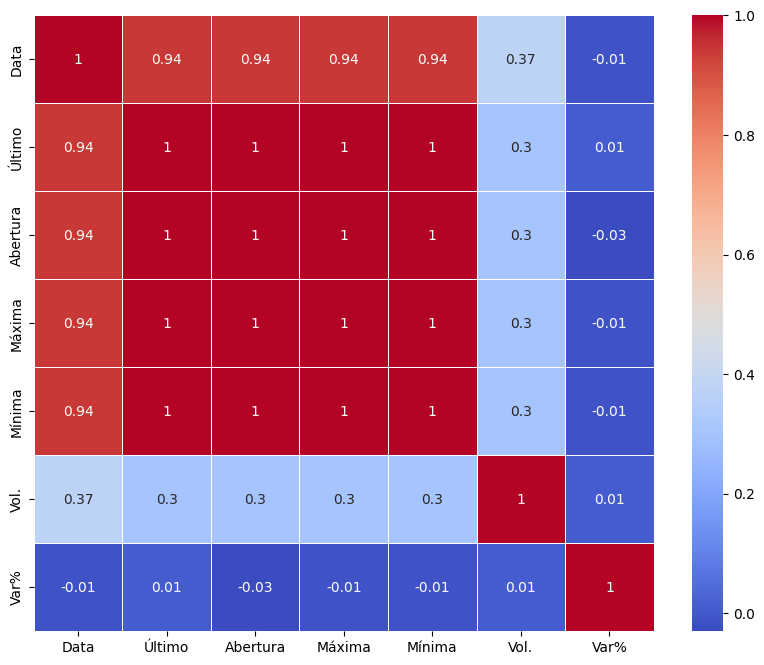

In [210]:
import seaborn as sns
import matplotlib.pyplot as plt

df_ibovespa['Var%'] = df_ibovespa['Var%'].astype(str).str.replace('%', '').str.replace(',', '.').astype(float) / 100

correlation_metrics = df_ibovespa.corr().round(2)

fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(correlation_metrics, annot=True,linewidths= .5, ax=ax, cmap="coolwarm")

plt.show()

In [211]:
df_ibovespa.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

#Iniciando o modelo

In [212]:
from sklearn import metrics
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_cross_validation_metric
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [213]:
df_ibovespa.rename(columns={'Data': 'ds', 'Último': 'y'}, inplace=True)
df_ibovespa.head()

,ds,y,Abertura,Máxima,Mínima,Vol.,Var%
0,2025-07-18,133.382,135.562,135.562,133.296,1.007000e+10,-0.0161
1,2025-07-17,135.565,135.515,135.792,135.016,6.800000e+09,0.0004
2,2025-07-16,135.511,135.250,135.641,134.265,7.830000e+09,0.0019
3,2025-07-15,135.250,135.298,136.022,134.380,6.900000e+09,-0.0004
4,2025-07-14,135.299,136.187,136.187,134.840,7.330000e+09,-0.0065


In [214]:
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        2615 non-null   datetime64[ns]
 1   y         2615 non-null   float64       
 2   Abertura  2615 non-null   float64       
 3   Máxima    2615 non-null   float64       
 4   Mínima    2615 non-null   float64       
 5   Vol.      2614 non-null   float64       
 6   Var%      2615 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 143.1 KB


In [215]:
df_ibovespa.set_index('ds', inplace=True)

df_ibovespa.reset_index(inplace=True)

train_set = df_ibovespa.iloc[:-30]

test_set = df_ibovespa.iloc[-30:]

m = Prophet()

m.fit(df_ibovespa)

22:47:13 - cmdstanpy - INFO - Chain [1] start processing
22:47:14 - cmdstanpy - INFO - Chain [1] done processing


In [216]:
future = m.make_future_dataframe(periods=60, freq='B')

forecast = m.predict(future)

#Apresentando os resultados

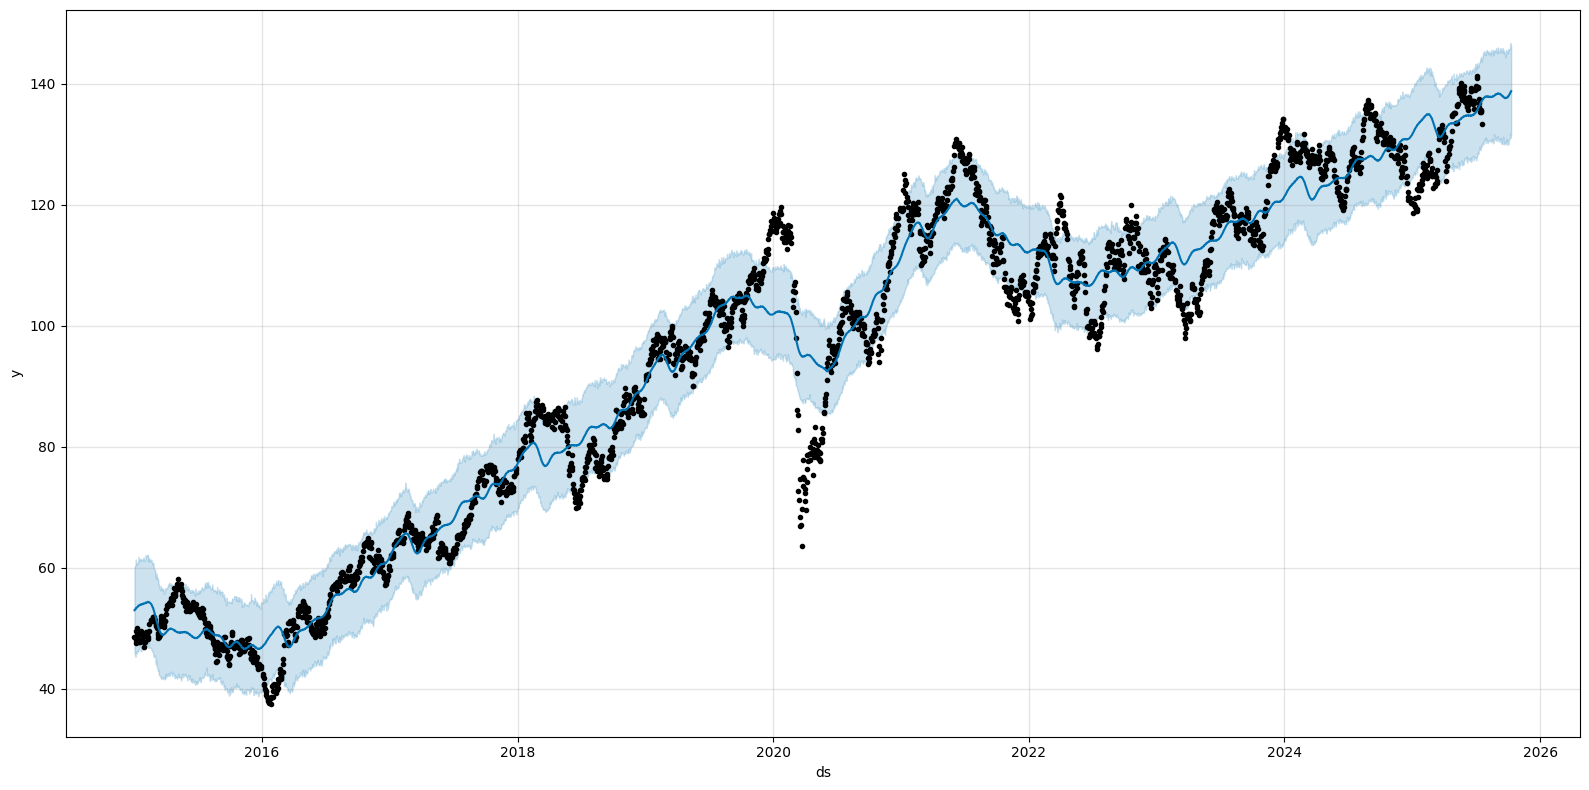

In [217]:
fig = m.plot(forecast, figsize=(16, 8))

In [218]:
import pandas as pd
import numpy as np

# Garante que as datas estão como datetime
df_ibovespa['ds'] = pd.to_datetime(df_ibovespa['ds'])
forecast['ds']    = pd.to_datetime(forecast['ds'])

# Data de corte (último ponto real)
data_corte = df_ibovespa['ds'].max()

# Próximos 30 dias previstos
forecast_future_30 = (
    forecast[
        (forecast['ds'] > data_corte) &
        (forecast['ds'] <= data_corte + pd.Timedelta(days=30))
    ]
    .copy()
    .reset_index(drop=True)
)

# 1) Pega o último valor real do IBOVESPA
last_real = df_ibovespa.loc[df_ibovespa['ds'] == data_corte, 'y'].values[0]

# 2) Cria coluna com o “valor do dia anterior” para comparar
forecast_future_30['prev'] = forecast_future_30['yhat'].shift(1)
forecast_future_30.loc[0, 'prev'] = last_real

# 3) Define Tendência: Subir se yhat > prev, senão Descer
forecast_future_30['Tendência'] = np.where(
    forecast_future_30['yhat'] > forecast_future_30['prev'],
    'Subir',
    'Descer'
)

# 4) Monta a tabela final
tabela = forecast_future_30[['ds', 'yhat', 'Tendência']]
tabela.columns = ['Data', 'Previsão_IBOVESPA', 'Tendência_Próximo_Dia']

# 5) Exibe
print(tabela.to_string(index=False))


      Data  Previsão_IBOVESPA Tendência_Próximo_Dia
2025-07-21         137.373520                 Subir
2025-07-22         137.542627                 Subir
2025-07-23         137.547887                 Subir
2025-07-24         137.617100                 Subir
2025-07-25         137.683656                 Subir
2025-07-28         137.772704                 Subir
2025-07-29         137.886583                 Subir
2025-07-30         137.837206                Descer
2025-07-31         137.853203                 Subir
2025-08-01         137.868772                 Subir
2025-08-04         137.825612                Descer
2025-08-05         137.904475                 Subir
2025-08-06         137.825465                Descer
2025-08-07         137.817571                Descer
2025-08-08         137.815239                Descer
2025-08-11         137.754957                Descer
2025-08-12         137.839891                 Subir
2025-08-13         137.772326                Descer
2025-08-14  

#Testando modelo #


In [219]:
m = Prophet()
m.fit(train_set)

22:47:14 - cmdstanpy - INFO - Chain [1] start processing
22:47:15 - cmdstanpy - INFO - Chain [1] done processing


In [220]:
future_test = test_set[['ds']]  # só as datas
forecast_test = m.predict(future_test)


In [221]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Valores reais
y_true = test_set['y'].values

# Previsões do modelo
y_pred = forecast_test['yhat'].values

# Métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 8.686857289286301
MSE: 76.2304030221997
RMSE: 8.731002406493753


In [222]:
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 17.94%



📈 Previsões dos próximos 30 dias:

      Data  Previsão_IBOVESPA Tendência_Próximo_Dia  Variação_%
2025-07-21           137.3735                 Subir        2.99
2025-07-22           137.5426                 Subir        0.12
2025-07-23           137.5479                 Subir        0.00
2025-07-24           137.6171                 Subir        0.05
2025-07-25           137.6837                 Subir        0.05
2025-07-28           137.7727                 Subir        0.06
2025-07-29           137.8866                 Subir        0.08
2025-07-30           137.8372                Descer       -0.04
2025-07-31           137.8532                 Subir        0.01
2025-08-01           137.8688                 Subir        0.01
2025-08-04           137.8256                Descer       -0.03
2025-08-05           137.9045                 Subir        0.06
2025-08-06           137.8255                Descer       -0.06
2025-08-07           137.8176                Descer       -0.01
2025

22:48:15 - cmdstanpy - INFO - Chain [1] start processing
22:48:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_5684\2813123372.py:118: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_5684\2813123372.py:118: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\T-GAMER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\T-GAMER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font

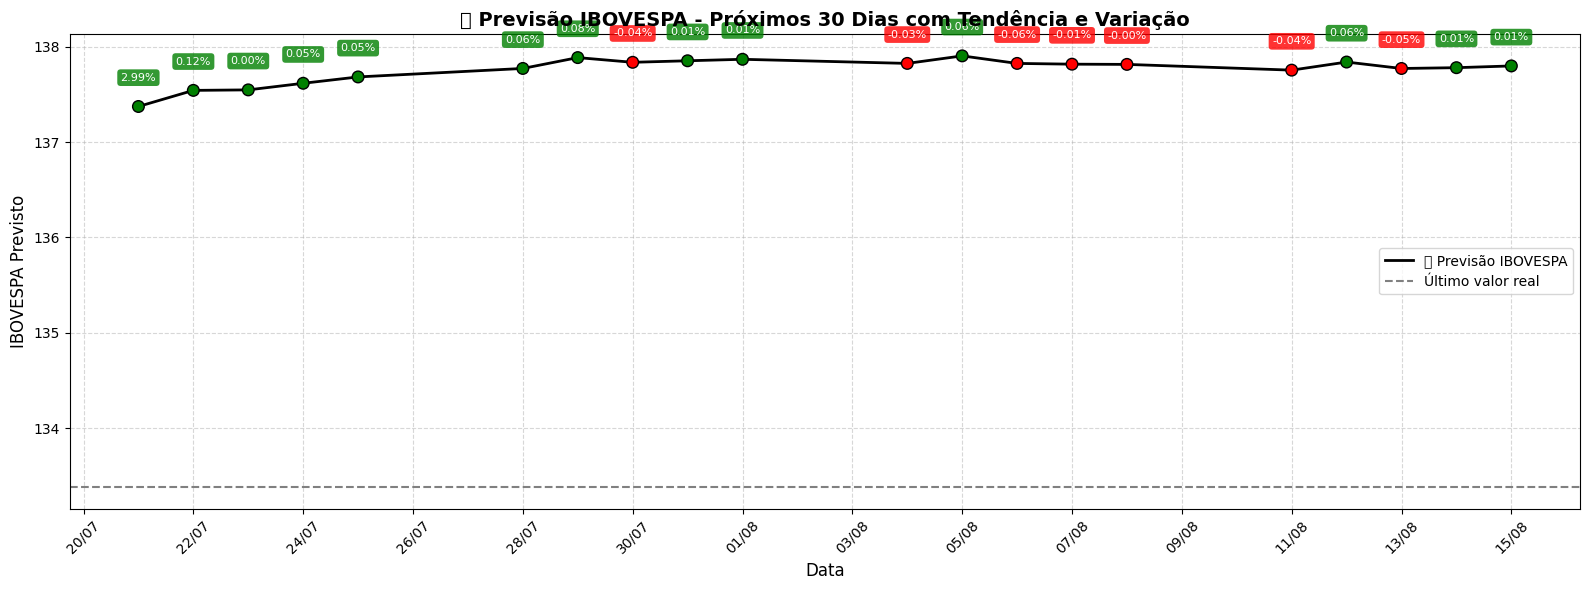

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Tratamento de datas ---
df_ibovespa['ds'] = pd.to_datetime(df_ibovespa['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Último valor real do IBOVESPA
last_real = df_ibovespa.loc[df_ibovespa['ds'] == df_ibovespa['ds'].max(), 'y'].values[0]

# Previsão dos próximos 30 dias
data_corte = df_ibovespa['ds'].max()
forecast_future_30 = forecast[
    (forecast['ds'] > data_corte) &
    (forecast['ds'] <= data_corte + pd.Timedelta(days=30))
].copy().reset_index(drop=True)

# Valor do dia anterior (shift) e variação
forecast_future_30['prev'] = forecast_future_30['yhat'].shift(1)
forecast_future_30.loc[0, 'prev'] = last_real

forecast_future_30['Tendência'] = np.where(
    forecast_future_30['yhat'] > forecast_future_30['prev'],
    'Subir',
    'Descer'
)

forecast_future_30['Variação_%'] = ((forecast_future_30['yhat'] - forecast_future_30['prev']) / forecast_future_30['prev']) * 100

tabela = forecast_future_30[['ds', 'yhat', 'Tendência', 'Variação_%']].copy()
tabela.columns = ['Data', 'Previsão_IBOVESPA', 'Tendência_Próximo_Dia', 'Variação_%']
tabela['Previsão_IBOVESPA'] = tabela['Previsão_IBOVESPA'].round(4)
tabela['Variação_%'] = tabela['Variação_%'].round(2)

print("\n📈 Previsões dos próximos 30 dias:\n")
print(tabela.to_string(index=False))


# --- Avaliação do modelo ---
y_true = test_set['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\n🔍 Métricas de desempenho do modelo:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


m = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # opcional
m.fit(train_set)

import matplotlib.pyplot as plt

data_limite = df_ibovespa['ds'].max() - pd.Timedelta(days=30)

df_real_3m = df_ibovespa[df_ibovespa['ds'] >= data_limite]
forecast_3m = forecast[forecast['ds'] >= data_limite]

# --- Gráfico da Previsão Futura (Próximos 30 dias) ---
# plt.figure(figsize=(12, 6))
# plt.plot(forecast_future_30['ds'], forecast_future_30['yhat'], label='Previsão - Próximos 30 dias', color='blue', marker='o')
# plt.title('📆 Previsão dos Próximos 30 Dias - IBOVESPA')
# plt.xlabel('Data')
# plt.ylabel('Previsão do IBOVESPA')
# plt.grid(True)
# plt.legend()
# plt.axhline(y=last_real, color='gray', linestyle='--', label='Último valor real')
# plt.tight_layout()
# plt.xticks(rotation=45)
# plt.show()
# Mapa de cores baseado na tendência
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Gráfico
fig, ax = plt.subplots(figsize=(14, 6))

# Linha principal
ax.plot(forecast_future_30['ds'], forecast_future_30['yhat'], color='black', linewidth=2, label='📈 Previsão IBOVESPA')

# Pontos coloridos por tendência
cores = forecast_future_30['Tendência'].map({'Subir': 'green', 'Descer': 'red'})
ax.scatter(forecast_future_30['ds'], forecast_future_30['yhat'], color=cores, s=70, edgecolor='black', zorder=5)

# Último valor real
ax.axhline(y=last_real, color='gray', linestyle='--', linewidth=1.5, label='Último valor real')

# Rótulos de variação com caixinha
for i, row in forecast_future_30.iterrows():
    ax.text(row['ds'], row['yhat'] + 0.25, f"{row['Variação_%']:.2f}%",
            ha='center', va='bottom', fontsize=8, color='white',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=cores[i], edgecolor='none', alpha=0.8))

# Formatação de datas
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Títulos e rótulos
plt.title('📊 Previsão IBOVESPA - Próximos 30 Dias com Tendência e Variação', fontsize=14, weight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('IBOVESPA Previsto', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()